# RNNs in PyTorch

Will be using RNN/LSTM modules.

Different steps:
* basic RNN setup
* managing RNN state
* truncated BPTT

In [1]:
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
rnn = torch.nn.RNN(input_size = 1, hidden_size = 10, num_layers = 1)

In [3]:
rnn_input = torch.zeros((100, 1, 1))

In [4]:
h_0 = torch.zeros((1, 1, 10))  # h_0 is the initial hidden state
# h_n is the last hidden state

In [5]:
outputs, final_state = rnn(rnn_input, h_0)

In [6]:
outputs.shape

torch.Size([100, 1, 10])

In [7]:
final_state.shape

torch.Size([1, 1, 10])

In [8]:
print(rnn.weight_hh_l0.shape)
print(rnn.weight_ih_l0.shape)
print(rnn.bias_hh_l0.shape)
print(rnn.bias_ih_l0.shape)

torch.Size([10, 10])
torch.Size([10, 1])
torch.Size([10])
torch.Size([10])


In [9]:
class MyRNN(nn.Module):
    def __init__(self):
        super(MyRNN, self).__init__()
        self.rnn = torch.nn.RNN(1, 10) # 1 dimension in, 10 dimensional 
        # hidden state
        self.output_layer = torch.nn.Linear(10, 1) # 10 dimension in,
        # 1 dimensional output
        
    def forward(self, x, h_0):
        rnn_outputs, h_n = self.rnn(x, h_0)
        outputs = self.output_layer(rnn_outputs)
        return outputs, h_n # outputs AND final hidden state

In [10]:
my_first_rnn = MyRNN()
outputs, h_n = my_first_rnn(rnn_input, h_0)

print(outputs.shape)
print(h_n.shape)

torch.Size([100, 1, 1])
torch.Size([1, 1, 10])


In [15]:
inputs = torch.randn((200, 1, 1))
targets = torch.zeros((200, 1, 1))
navg = 5

for ii in range(navg, inputs.shape[0]):
    targets[ii] = inputs[ii - navg:ii].mean()

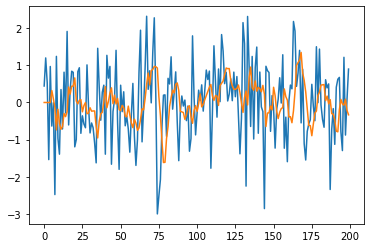

In [16]:
plt.plot(inputs.squeeze())
plt.plot(targets.squeeze())

In [17]:
model = MyRNN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .01)

In [18]:
nepoch = 100

for epoch in range(nepoch):
    optimizer.zero_grad()
    outputs, h_n = model(inputs, h_0)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    if not epoch%10:
        print("Loss(%d):"%epoch, loss.mean())

Loss(0): tensor(0.2754, grad_fn=<MeanBackward0>)
Loss(10): tensor(0.1429, grad_fn=<MeanBackward0>)
Loss(20): tensor(0.0660, grad_fn=<MeanBackward0>)
Loss(30): tensor(0.0413, grad_fn=<MeanBackward0>)
Loss(40): tensor(0.0324, grad_fn=<MeanBackward0>)
Loss(50): tensor(0.0257, grad_fn=<MeanBackward0>)
Loss(60): tensor(0.0200, grad_fn=<MeanBackward0>)
Loss(70): tensor(0.0148, grad_fn=<MeanBackward0>)
Loss(80): tensor(0.0103, grad_fn=<MeanBackward0>)
Loss(90): tensor(0.0058, grad_fn=<MeanBackward0>)


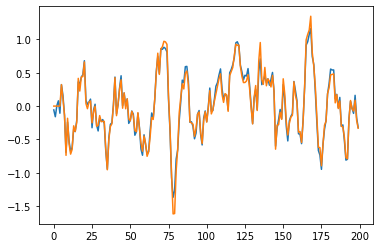

In [19]:
plt.plot(outputs.squeeze().detach())
plt.plot(targets.squeeze())

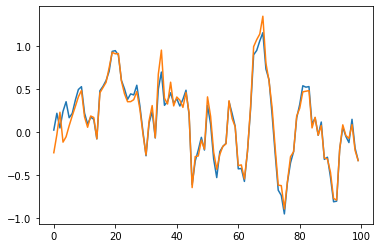

In [23]:
with torch.no_grad():
    test_outputs, _ = model(inputs[100:], h_n)
    plt.plot(test_outputs.squeeze().detach())
    
plt.plot(targets[100:].squeeze())

# Truncated BPTT

In [24]:
inputs2 = torch.randn((2000, 1, 1))
targets2 = torch.zeros((2000, 1, 1))
navg = 5

for ii in range(navg, inputs2.shape[0]):
    targets2[ii] = inputs2[ii - navg:ii].mean()

In [25]:
model2 = MyRNN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = .01)

In [28]:
# basically training on a sliding window that looks at 100 data points at a time. 
# Then it slides to the next 100 and continues until all 2000 points have been learned from


nepoch = 3

data_ptr = 0 # data pointer: where we should start on the BPTT run
seq_len = 100 # how long each training sequence be

for epoch in range(nepoch):
    dta_ptr = 0
    h = torch.zeros((1,1,10))
    while True:
        optimizer.zero_grad()
        outputs, h = model2(inputs2[data_ptr:data_ptr + seq_len], h.detach())
        loss = criterion(outputs, targets2[data_ptr:data_ptr + seq_len])
        loss.backward()
        optimizer.step()
        
        data_ptr += seq_len
        if data_ptr + seq_len > inputs2.shape[0]:
            data_ptr = 0
            break
            
    print("Loss(%d):"%epoch, loss.mean())

Loss(0): tensor(0.0562, grad_fn=<MeanBackward0>)
Loss(1): tensor(0.0257, grad_fn=<MeanBackward0>)
Loss(2): tensor(0.0173, grad_fn=<MeanBackward0>)


# Batching

In [29]:
inputs3 = torch.randn((2000, 5, 1))
targets3 = torch.zeros((2000, 5, 1))
navg = 5

for ii in range(navg, inputs3.shape[0]):
    targets3[ii] = inputs3[ii - navg:ii].mean()

In [30]:
print(inputs3.shape, targets3.shape)

torch.Size([2000, 5, 1]) torch.Size([2000, 5, 1])


In [32]:
model3 = MyRNN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr = .01)

In [36]:
nepoch = 100

for epoch in range(nepoch):
    optimizer.zero_grad()
    outputs, h_n = model3(inputs3[:100], torch.zeros((1,5,10))) # need to set up hidden state
    loss = criterion(outputs, targets3[:100])
    loss.backward()
    optimizer.step()
    if not epoch%10:
        print("Loss(%d):"%epoch, loss.mean())

Loss(0): tensor(0.0525, grad_fn=<MeanBackward0>)
Loss(10): tensor(0.0283, grad_fn=<MeanBackward0>)
Loss(20): tensor(0.0263, grad_fn=<MeanBackward0>)
Loss(30): tensor(0.0251, grad_fn=<MeanBackward0>)
Loss(40): tensor(0.0236, grad_fn=<MeanBackward0>)
Loss(50): tensor(0.0231, grad_fn=<MeanBackward0>)
Loss(60): tensor(0.0228, grad_fn=<MeanBackward0>)
Loss(70): tensor(0.0226, grad_fn=<MeanBackward0>)
Loss(80): tensor(0.0225, grad_fn=<MeanBackward0>)
Loss(90): tensor(0.0223, grad_fn=<MeanBackward0>)


# LSTM

In [38]:
class MyLSTM(nn.Module):
    def __init__(self):
        super(MyLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(1,10)
        self.output_layer = torch.nn.Linear(10,1)
        
    def forward(self, x, hc_0):
        lstm_outputs, hc_n = self.lstm(x, hc_0)
        outputs = self.output_layer(lstm_outputs)
        return outputs, hc_n

In [39]:
model4 = MyLSTM()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr = .01)

In [40]:
inputs4 = torch.randn((200, 1, 1))
targets4 = torch.zeros((200, 1, 1))
navg = 5

for ii in range(navg, inputs4.shape[0]):
    targets4[ii] = inputs4[ii - navg:ii].mean()

In [42]:
nepoch = 100

hc_0 = (torch.zeros((1,1,10)), torch.zeros((1,1,10)))

for epoch in range(nepoch):
    optimizer.zero_grad()
    outputs, hc_n = model4(inputs4[:100], hc_0) 
    loss = criterion(outputs, targets4[:100])
    loss.backward()
    optimizer.step()
    if not epoch%10:
        print("Loss(%d):"%epoch, loss.mean())

Loss(0): tensor(0.2655, grad_fn=<MeanBackward0>)
Loss(10): tensor(0.1626, grad_fn=<MeanBackward0>)
Loss(20): tensor(0.0791, grad_fn=<MeanBackward0>)
Loss(30): tensor(0.0409, grad_fn=<MeanBackward0>)
Loss(40): tensor(0.0369, grad_fn=<MeanBackward0>)
Loss(50): tensor(0.0307, grad_fn=<MeanBackward0>)
Loss(60): tensor(0.0263, grad_fn=<MeanBackward0>)
Loss(70): tensor(0.0228, grad_fn=<MeanBackward0>)
Loss(80): tensor(0.0204, grad_fn=<MeanBackward0>)
Loss(90): tensor(0.0185, grad_fn=<MeanBackward0>)
